In [22]:
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import numpy as np
from keras.models import load_model
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt
from keras.models import model_from_json
import random
import sys

## Preprocessing

In [7]:
df_lyrics = pd.read_csv('lyrics_cleaned.csv')

In [8]:
pd.set_option('display.max_rows', None)
df_hiphop = df_lyrics[df_lyrics['genre']=='hiphop']
df_hiphop

,track_name,artist_name,genre,lyrics,cleaned_lyrics
1679,Moment Of Truth,Gang Starr,hiphop,[intro: sharon]no matter what we facewe must f...,no matter what we facewe must face the moment...
1680,Eazy-er Said Than Dunn,Eazy-E,hiphop,"\n\n[intro: dr. dre]\nyo' man, i don't think t...",yo man i don t think they heard you won t you...
1681,Fight Night,Migos,hiphop,"\n\n[intro: takeoff]\nif you know me, know thi...",if you know me know this ain t my feng shui c...
1682,Studio,ScHoolboy Q,hiphop,[produced by swiff d][chorus: bj the chicago k...,i m just sittin in the studio just tryna get ...
1683,Flex Like Ouu,Lil Pump,hiphop,"[intro]ooh, oohlil pumpayy, ayy, ayyoh my god,...",ooh oohlil pumpayy ayy ayyoh my god ronny mov...
1684,Fr Fr (feat. Lil Skies),Wiz Khalifa,hiphop,\n\n[intro: wiz khalifa]\nyeah\n\n[chorus: wiz...,yeah nigga for real for real my niggas is rea...
1685,Time for That,Kevin Gates,hiphop,\n\n[intro]\nyeah\n\n[hook]\ndo you think i’ll...,yeah do you think i ll ever need you love mor...
1686,Rich As Fuck,Lil Wayne,hiphop,"[verse 1: lil wayne]uh, ak on my nightstand, r...",uh ak on my nightstand right next to that bib...
1687,Remember You (feat. Blackbear),G-Eazy,hiphop,[chorus: blackbear]i will remember youshe got ...,i will remember youshe got her own crib with ...
1688,Nobody Move,Eazy-E,hiphop,"\n\n[intro]\neazy-e: yo ren, you're ready to g...",eazy e yo ren you re ready to go get this mon...


In [9]:
text = []
for index,row in df_hiphop['cleaned_lyrics'].iteritems():
    text.append(str(row).lower())
    
flat_text = [item for elem in text for item in elem]
chars = sorted(list(set(flat_text)))

In [6]:
print("\nTotal distinct chars : ", len(chars))
print(chars)
print("\n\nFinal Composition of corpus : ")

total_char_count = 0
for char in chars:
    char_count = flat_text.count(char)
    total_char_count += char_count
    print(char, " : ", char_count)

print("\n\n")
print(len(flat_text),"==", total_char_count)


Total distinct chars :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Final Composition of corpus : 
   :  226733
a  :  65873
b  :  16054
c  :  22498
d  :  29122
e  :  90060
f  :  14327
g  :  24037
h  :  47704
i  :  66446
j  :  2353
k  :  16469
l  :  35704
m  :  28264
n  :  59071
o  :  69504
p  :  16261
q  :  431
r  :  38084
s  :  47040
t  :  77276
u  :  30578
v  :  6513
w  :  20272
x  :  1010
y  :  27755
z  :  1020



1080459 == 1080459


In [10]:
# dividing dataset lyrics into sentences and next character prediction
input_text = []
next_char_prediction = []
lyrics = df_hiphop['cleaned_lyrics'].tolist()

INPUT_TEXT_LEN_FIXED = 20

for each_lyric in lyrics:
    
    for i in range(0, len(each_lyric) - INPUT_TEXT_LEN_FIXED):
        
        input_text.append(each_lyric[i: i + INPUT_TEXT_LEN_FIXED])
        next_char_prediction.append(each_lyric[i + INPUT_TEXT_LEN_FIXED])
        
print("Total Sentences : ", len (input_text))
print("Total Next Character Predictions : ", len (next_char_prediction))
print("Length of each sentence : ", len(input_text[345])) # Random index
print("Length of each next output : ", len(next_char_prediction[214])) # Random index

Total Sentences :  1070339
Total Next Character Predictions :  1070339
Length of each sentence :  20
Length of each next output :  1


In [11]:
# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

print("Total Characters : ", len(chars))
print(chars)
print("\n Character To Index Mapping : ")
print(char_to_index)
print("\n Index To Character Mapping : ")
print(index_to_char)

Total Characters :  27
[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

 Character To Index Mapping : 
{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

 Index To Character Mapping : 
{0: ' ', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [12]:

# Now vectorizing the dataset so that it can be fed to the LSTM model

# Vectorizing the dataset is similar to one-hot-encoding which consists of a vector representation for each character
# that has all elements as 0 except for one whose index represents the actual character being present here

x = np.zeros((len(input_text), INPUT_TEXT_LEN_FIXED, len(chars)), dtype=np.bool)
y = np.zeros((len(next_char_prediction), len(chars)), dtype=np.bool)

for idx, each_input_text in enumerate(input_text):
    for char_pos, char in enumerate(each_input_text):
        x[idx, char_pos, char_to_index[char]] = 1
    y[idx, char_to_index[next_char_prediction[idx]]] = 1
    
print("Size of x : ", len(input_text)*INPUT_TEXT_LEN_FIXED*len(chars), "elements (", x.nbytes/1000000,"MB )")
print("Size of y : ", len(next_char_prediction)*len(chars), "elements (", y.nbytes/1000000,"MB )")

Size of x :  577983060 elements ( 577.98306 MB )
Size of y :  28899153 elements ( 28.899153 MB )


## Train the model
### (Don't run this part if you are just viewing)

In [10]:


# Lyrics Generation Model

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(INPUT_TEXT_LEN_FIXED, len(chars))))
model.add(LSTM(128))
model.add(Dense(100, activation='relu'))
model.add(Dense(len(chars), activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           290816    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 27)                2727      
Total params: 503,563
Trainable params: 503,563
Non-trainable params: 0
_________________________________________________________________


In [18]:
# helper function to sample an index from a probability array
def sample(preds, temperature=1.0):
    epsilon = 1e-08
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + epsilon) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [12]:
import random
import sys

# Function invoked at end of each epoch. Prints generated text.
def on_epoch_end(epoch, _):
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - INPUT_TEXT_LEN_FIXED - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        pos = random.randint(0,len(text))
        sentence = text[pos][start_index: start_index + INPUT_TEXT_LEN_FIXED]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [13]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping =keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [14]:
history = model.fit(x, y,
          batch_size=32,
          epochs=100,
         callbacks=[print_callback,early_stopping])

Epoch 1/100
33449/33449 [==============================] - 1931s 58ms/step - loss: 1.8771 - accuracy: 0.4396

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "rom beside me cause "
rom beside me cause i m so i m a straight up the street s a back in the same that s a change the back in the carter and stay i m a lot of my back that s when i m the cards i m a straight up in the corner than i m so i m a street to the catch i m the can t start the streets to the come of the stand i m here the gang i m so i m the cart on my come on my thorn and i m the stand that s a strip that s the stand that s a b
----- diversity: 0.5
----- Generating with seed: " stage drippin pouri"
 stage drippin pouring in the gangsta show i m real homies the dick and i m so i m so i m the way some time to do you ain t the pop in the old on to the claps in the chile with the way i got a come of the whole we wanna get some time to the carty i m a street with the way the wrong cause

xwatch out for haitiaterds who try to sellweet it lateryou write g s a s or been aw youefuckin i m possessed to make the crib we wet it we den e part bullshit yeah i m getting homies you like it naugo i said you can t have it you cake my cube what it is queinen bags like arranim porter man i in the floor death on me your hands or clipped mo don t get projects exizan yetheyfers gamegirl just leave me livin like they a
----- diversity: 1.2
----- Generating with seed: "heart s in the junky"
heart s in the junkyeauzing it i paid brack girls in none of this while me fond thingsgowmantistandsopen wire waf ishle today for felf mat times figuresix full of copyright all shoesoowif bitch go woo doo leyou just that shit nigga yuh tryna funk themone good germen before crist maynework it em thum it s just the gator i walk i ll bug i have goenta indeed the knew my momin like faceleft to ob strang eightic on my han
Epoch 9/100
33449/33449 [==============================] - 1773s 53ms/step - loss: 1.1

igner esskeetitooh like and the streets and i m still to live i ma still want that ass on me i m just so fresh so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so clean so 
----- diversity: 0.5
----- Generating with seed: "her god i just wanna"
her god i just wanna see you been a long year man that s a bitch ass look at my clothes you know what i m sayin i m sorry ms jackson or my nigga my nigga my nigga like i m a little money she got me goin psycho grip your eyes only sound all of us every day my money family someone said stay featurience in sound stand to god i m on a nigga i ll be too big boys be my past i can t be so case all my grand around the stair 
----- diversity: 1.0
----- Generating with seed: "oohmy life be like o"
oohmy life be 

eat a lyricist who not stiminal if they re alreadyo trapper when i take it  nigga ride with my last if you don t want stakes with a ho niggadilla brown for pathaifted red hy i just give him cool future nobody like a persee underm day and i stay been on off the none of your feet you gotta get some pussy she wanna go and wake up and just wanna fuck hom to spoke e s it sack with sellin rocks and watchers and all right i
----- diversity: 1.2
----- Generating with seed: "ockhampton oh boy la"
ockhampton oh boy lamb toies of hatled in her blast lextor all count and mmi ma show you to havin famous mike ugerhy ral portion never left through they the swerdon mento vovabba gon link iverssyou call it s fuck acin dausin and young aksickin it s comin in numas splitssomething alwaysyon for you to red my kind i buy dancin til i plaque yeah you wanna split everybody getting high play to hack my styles and uh some co
Epoch 24/100
33449/33449 [==============================] - 4083s 122ms/step - loss: 0

t conebut my double but i m still in the street i m peeling my heart is a storm she said i was really tryna find that shit in the street i m peeling the truth i m still in the back of the bus do you wanna bump and slump with us we the type of people make the club get crunk i m sick of the cash on me like i m a new chain i m a throw it ain t safe it ain t said i m still all in the streets so i can fuck the booze i m s
----- diversity: 0.5
----- Generating with seed: "nd it girl you re ma"
nd it girl you re makin it hard for me i m goin crazy all these bitches tryna set the men do short jegn more to liquer i m not the fast while i m in the south on the door she s sayin i don t want you to waste in the stakes i m countin up feel like real high as kickin cause i m going to get that legit of no then the twenty of niggas talkin i m tryna get the partner of the rap to how we be flippin i m in love with a st
----- diversity: 1.0
----- Generating with seed: "r if she ever call m"
r if she ever 

dict_keys(['loss', 'accuracy'])


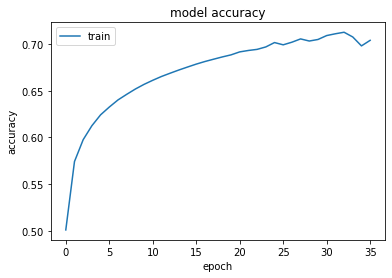

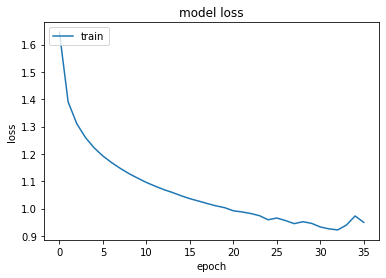

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("models/hiphop_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/hiphop_model.h5")
print("Saved model to disk")

Saved model to disk


## Load the model

In [23]:
# load json and create model
json_file = open('models/hiphop_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("models/hiphop_model.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
# evaluate the accuracy of model
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])

score = model.evaluate(x, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 71.38%


In [25]:
def predict_lyrics(seed):

    for diversity in [0.1, 0.2,0.4,0.6,0.8,1.0,1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = seed[:INPUT_TEXT_LEN_FIXED].lower()
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, INPUT_TEXT_LEN_FIXED, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_to_index[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = index_to_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [26]:
# Model is trained to take 30 chars as input
INPUT_TEXT_LEN_FIXED = 20 

# Lyrics Alphabet Dictionary
chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# Create a dictionary mapping from character to index 
char_to_index = dict((c, i) for i, c in enumerate(chars))

# Create a dictionary mapping from index to character 
index_to_char = dict((i, c) for i, c in enumerate(chars))

In [27]:
seed = "you left without saying"

# Given function will use the seed string to generate the most probable next 350 characters
# Let's see what the model has learned!
predict_lyrics(seed)

----- diversity: 0.1
----- Generating with seed: "you left without say"
you left without saying i m sippin on a spike a bangin on the street i m on some real shit yeah i m tryna start the thorn and sold our conscience infacties and the streets i m the one that s a new wrist and i ain t tryin to sell lie in the club and i ain t got the same shit to the face i m the one that s a no no now that s a lot of cash fuck the police trick ass nigga stay right now and i m a black man i m the nigga 
----- diversity: 0.2
----- Generating with seed: "you left without say"
you left without saying i m the nigga with a blunt and i m smoking for me what the fuck you can t stand itmy heart can t have none it ain t no fun if the home s what i m always the shit is a block that s a motherfuckin starting and a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a party it s a part
----- diversit